# Benchmark QRT

This notebook illustrates a simple benchmark example that should help novice participants to start the competition.

## Used libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [2]:
x_train = pd.read_csv('../data/x_train.csv', index_col='ID')
y_train = pd.read_csv('../data/y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('../data/x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


## Feature Engineering

The main drawback in this challenge would be to deal with the noise. To do that, we could create some feature that aggregate features with some statistics. 

The following cell computes statistics on a given target conditionally to some features. For example, we want to generate a feature that describe the mean of `RET_1` conditionally to the `SECTOR` and the `DATE`.

**Ideas of improvement**: change shifts, the conditional features, the statistics, and the target. 

In [3]:
# Feature engineering
new_features = []

# Conditional aggregated features
shifts = [i for i in range(1,21)]  # Choose some different shifts
statistics = ['mean']  # the type of stat

# # GROUP BY 4 features only for "RET", shifts = [1,...,21]
# gb_features = ['STOCK','SECTOR','INDUSTRY', 'DATE']
# target_feature = ['RET']
# tmp_name = '_'.join(gb_features)
# for j in target_feature:
#     for shift in shifts:
#         for stat in statistics:
#             name = f'{j}_{shift}_{tmp_name}_{stat}'
#             feat = f'{j}_{shift}'
#             new_features.append(name)
#             for data in [train, test]:
#                 data[name] = data.groupby(gb_features)[feat].transform(stat)
           
        
# # GROUP BY "DATE" for features['RET','VOLUME'], shifts=[1,...,21]
# gb_features = ['DATE']
# target_features = ['RET','VOLUME']
# tmp_name = '_'.join(gb_features)
# for j in target_features:
# #     target_feature = j
#     for shift in shifts:
#         for stat in statistics:
#             name = f'{j}_{shift}_{tmp_name}_{stat}'
#             feat = f'{j}_{shift}'
#             new_features.append(name)
#             for data in [train, test]:
#                 data[name] = data.groupby(gb_features)[feat].transform(stat)

        
# GROUP BY "STOCK" for features['RET','VOLUME'], shifts=[1,...,21]
gb_features = ['STOCK']
target_features = ['RET','VOLUME']
tmp_name = '_'.join(gb_features)
for j in target_features:
#     target_feature = j
    for shift in shifts:
        for stat in statistics:
            name = f'{j}_{shift}_{tmp_name}_{stat}'
            feat = f'{j}_{shift}'
            new_features.append(name)
            for data in [train, test]:
                data[name] = data.groupby(gb_features)[feat].transform(stat)

                
gb_features = ['STOCK','SECTOR','INDUSTRY', 'DATE']
target_feature = "VOLUME"
shifts = [1,13]
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}_{shift}'
        new_features.append(name)
        for data in [train, test]:
            data[name] = data.groupby(gb_features)[feat].transform(stat)
            


## Feature selection

To reduce the number of feature (and the noise) we only consider the 5 last days of `RET` and `VOLUME` in addition to the newly created feature.

In [4]:
target = 'RET'

n_shifts = [1,2,3,7,14,17]
features = ['RET_%d' % i for i in n_shifts]
# features += ['VOLUME_1','DATE']
features += ['VOLUME_1']

features += new_features  # The conditional features
train[features].head()

,RET_1,RET_2,RET_3,RET_7,RET_14,RET_17,VOLUME_1,RET_1_STOCK_mean,RET_2_STOCK_mean,RET_3_STOCK_mean,...,VOLUME_13_STOCK_mean,VOLUME_14_STOCK_mean,VOLUME_15_STOCK_mean,VOLUME_16_STOCK_mean,VOLUME_17_STOCK_mean,VOLUME_18_STOCK_mean,VOLUME_19_STOCK_mean,VOLUME_20_STOCK_mean,VOLUME_1_STOCK_SECTOR_INDUSTRY_DATE_mean,VOLUME_13_STOCK_SECTOR_INDUSTRY_DATE_mean
ID,,,,,,,,,,,,,,,,,,,,,
0,-0.015748,-0.015504,0.010972,-0.017215,-0.049370,0.003254,0.147931,0.001285,0.003829,0.000226,...,-0.254376,-0.368684,-0.320473,-0.413497,-0.346483,-0.261443,-0.171050,-0.182507,0.147931,-0.244636
1,0.003984,-0.090580,0.018826,-0.026756,-0.052044,0.003774,NaN,0.005551,-0.004266,-0.000460,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.000440,-0.058896,-0.009042,-0.023047,-0.002686,-0.017612,-0.096282,0.001534,0.000244,0.002516,...,-0.076037,-0.109735,-0.002067,-0.044647,-0.064004,0.023585,-0.045170,0.004909,-0.096282,-0.081783
3,0.031298,0.007756,-0.004632,-0.043962,0.000479,0.033824,-0.429540,0.001422,-0.002775,0.002287,...,-0.057720,-0.285352,-0.306822,-0.109386,-0.316047,-0.157600,-0.199309,0.088587,-0.429540,-0.839232
4,0.027273,-0.039302,0.000000,-0.026549,0.095891,-0.012659,-0.847155,0.001017,0.003006,-0.000166,...,0.011901,0.444344,1.491632,-0.095353,-0.111839,-0.100428,0.981283,-0.155964,-0.847155,0.271702


In [5]:
list(train[features].iloc[:0])

['RET_1',
 'RET_2',
 'RET_3',
 'RET_7',
 'RET_14',
 'RET_17',
 'VOLUME_1',
 'RET_1_STOCK_mean',
 'RET_2_STOCK_mean',
 'RET_3_STOCK_mean',
 'RET_4_STOCK_mean',
 'RET_5_STOCK_mean',
 'RET_6_STOCK_mean',
 'RET_7_STOCK_mean',
 'RET_8_STOCK_mean',
 'RET_9_STOCK_mean',
 'RET_10_STOCK_mean',
 'RET_11_STOCK_mean',
 'RET_12_STOCK_mean',
 'RET_13_STOCK_mean',
 'RET_14_STOCK_mean',
 'RET_15_STOCK_mean',
 'RET_16_STOCK_mean',
 'RET_17_STOCK_mean',
 'RET_18_STOCK_mean',
 'RET_19_STOCK_mean',
 'RET_20_STOCK_mean',
 'VOLUME_1_STOCK_mean',
 'VOLUME_2_STOCK_mean',
 'VOLUME_3_STOCK_mean',
 'VOLUME_4_STOCK_mean',
 'VOLUME_5_STOCK_mean',
 'VOLUME_6_STOCK_mean',
 'VOLUME_7_STOCK_mean',
 'VOLUME_8_STOCK_mean',
 'VOLUME_9_STOCK_mean',
 'VOLUME_10_STOCK_mean',
 'VOLUME_11_STOCK_mean',
 'VOLUME_12_STOCK_mean',
 'VOLUME_13_STOCK_mean',
 'VOLUME_14_STOCK_mean',
 'VOLUME_15_STOCK_mean',
 'VOLUME_16_STOCK_mean',
 'VOLUME_17_STOCK_mean',
 'VOLUME_18_STOCK_mean',
 'VOLUME_19_STOCK_mean',
 'VOLUME_20_STOCK_mean',
 'V

## Model and local score

A Random Forest (RF) model is chosen for the Benchmark. We consider a large number of tree with a quiet small depth. The missing values are simply filled with 0. A KFold is done on the dates (using `DATE`) for a local scoring of the model. 

**Ideas of improvements**: Tune the RF hyperparameters, deal with the missing values, change the features, consider another model, ...

In [6]:
X_train = train[features]
y_train = train[target]

# A quiet large number of trees with low depth to prevent overfits
rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
}

train_dates = train['DATE'].unique()
test_dates = test['DATE'].unique()

n_splits = 4
scores = []

models = []

splits = KFold(n_splits=n_splits, random_state=0,
               shuffle=True).split(train_dates)

for i, (local_train_dates_ids, local_test_dates_ids) in enumerate(splits):
    local_train_dates = train_dates[local_train_dates_ids]
    local_test_dates = train_dates[local_test_dates_ids]

    local_train_ids = train['DATE'].isin(local_train_dates)
    local_test_ids = train['DATE'].isin(local_test_dates)

    X_local_train = X_train.loc[local_train_ids]
    y_local_train = y_train.loc[local_train_ids]
    X_local_test = X_train.loc[local_test_ids]
    y_local_test = y_train.loc[local_test_ids]

    X_local_train = X_local_train.fillna(0)
    X_local_test = X_local_test.fillna(0)

    model = RandomForestClassifier(**rf_params)
    model.fit(X_local_train, y_local_train)

    y_local_pred = model.predict_proba(X_local_test)[:, 1]
    
    sub = train.loc[local_test_ids].copy()
    sub['pred'] = y_local_pred
    y_local_pred = sub.groupby('DATE')['pred'].transform(lambda x: x > x.median()).values

    models.append(model)
    score = accuracy_score(y_local_test, y_local_pred)
    scores.append(score)
    print(f"Fold {i+1} - Accuracy: {score* 100:.2f}%")

mean = np.mean(scores)*100
std = np.std(scores)*100
u = (mean + std)
l = (mean - std)
print(f'Accuracy: {mean:.2f}% [{l:.2f} ; {u:.2f}] (+- {std:.2f})')

Fold 1 - Accuracy: 53.14%
Fold 2 - Accuracy: 51.29%
Fold 3 - Accuracy: 51.34%
Fold 4 - Accuracy: 51.92%
Accuracy: 51.92% [51.18 ; 52.67] (+- 0.75)


<AxesSubplot:>

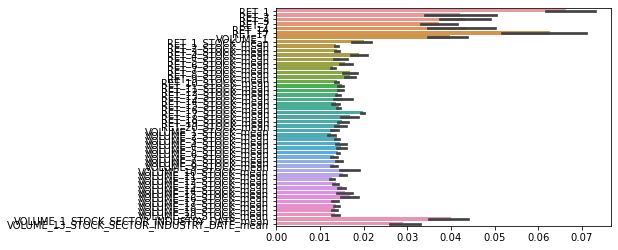

In [7]:
feature_importances = pd.DataFrame([model.feature_importances_ for model in models], columns=features)

# sns.barplot(data=feature_importances, orient='h', order=feature_importances.mean().sort_values(ascending=False).index)/
sns.barplot(data=feature_importances, orient='h')

<AxesSubplot:>

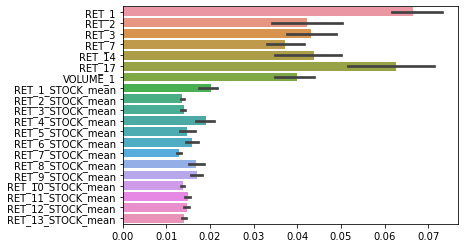

In [8]:
sns.barplot(data=feature_importances.iloc[:,:20], orient='h')

<AxesSubplot:>

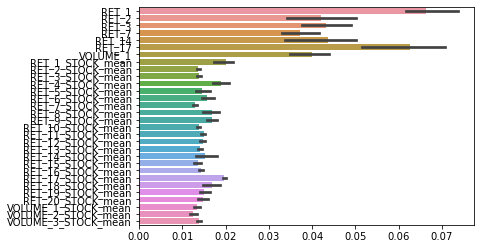

In [9]:
sns.barplot(data=feature_importances.iloc[:,:30], orient='h')

<AxesSubplot:>

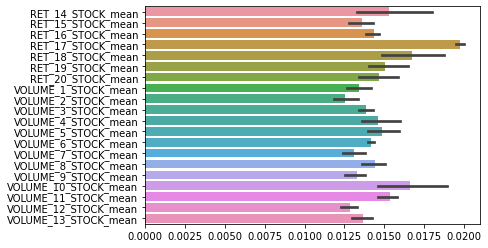

In [10]:
sns.barplot(data=feature_importances.iloc[:,20:40], orient='h')

<AxesSubplot:>

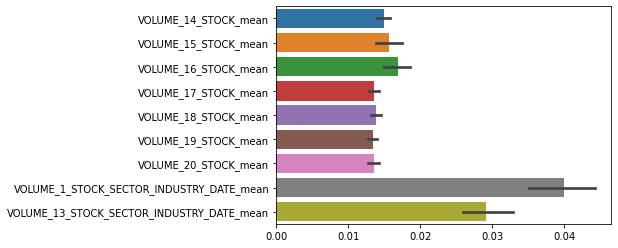

In [11]:
sns.barplot(data=feature_importances.iloc[:,40:80], orient='h')

In [12]:
# sns.barplot(data=feature_importances.iloc[:,80:100], orient='h')

In [13]:
# sns.barplot(data=feature_importances.iloc[:,100:], orient='h')

## Generate the submission

The same parameters of the RF model are considered. With that we build a new RF model on the entire `train` dataset. The predictions are saved in a `.csv` file.

In [14]:
X_test = test[features]

# rf_params['random_state'] = 0
# model = RandomForestClassifier(**rf_params)
# model.fit(X_train.fillna(0), y_train)
y_pred = model.predict_proba(X_test.fillna(0))[:, 1]

sub = test.copy()
sub['pred'] = y_pred
y_pred = sub.groupby('DATE')['pred'].transform(
    lambda x: x > x.median()).values

submission = pd.Series(y_pred)
submission.index = test.index
submission.name = target

submission.to_csv('./RF.csv', index=True, header=True)

In [15]:
X_test.fillna(0)

,RET_1,RET_2,RET_3,RET_7,RET_14,RET_17,VOLUME_1,RET_1_STOCK_mean,RET_2_STOCK_mean,RET_3_STOCK_mean,...,VOLUME_13_STOCK_mean,VOLUME_14_STOCK_mean,VOLUME_15_STOCK_mean,VOLUME_16_STOCK_mean,VOLUME_17_STOCK_mean,VOLUME_18_STOCK_mean,VOLUME_19_STOCK_mean,VOLUME_20_STOCK_mean,VOLUME_1_STOCK_SECTOR_INDUSTRY_DATE_mean,VOLUME_13_STOCK_SECTOR_INDUSTRY_DATE_mean
ID,,,,,,,,,,,,,,,,,,,,,
418595,0.020208,0.010059,0.002192,-0.001611,-0.001872,-0.001035,0.146176,-0.000978,0.001012,0.003876,...,-0.154222,-0.172741,-0.152972,-0.140516,-0.049771,0.086478,0.048618,-0.037165,0.146176,0.060668
418596,0.009134,0.021913,-0.007251,-0.017356,-0.012690,-0.001544,-0.251631,0.001458,0.002239,0.003075,...,-0.010842,-0.177813,-0.114222,-0.095669,-0.155002,-0.097353,-0.075824,-0.064463,-0.251631,-0.386691
418597,0.005008,0.005914,-0.003927,-0.012561,-0.006913,0.011481,-0.115845,0.000971,0.001664,0.001162,...,-0.160359,-0.152504,-0.129501,-0.188287,-0.035435,0.004778,-0.063279,-0.085349,-0.115845,-0.336112
418598,0.015370,-0.013738,0.008600,0.027742,0.004847,0.037018,-0.090295,0.001765,0.001173,0.001337,...,-0.059922,0.220587,0.311403,-0.036874,-0.021407,0.004597,-0.095876,-0.100258,-0.090295,-0.350864
418599,0.011419,0.022807,0.014645,-0.004834,-0.022215,0.004304,-0.289027,-0.001729,0.001814,0.002337,...,0.140308,0.137445,0.123044,0.267147,-0.017483,0.182909,0.076440,0.083234,-0.289027,-0.285158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617019,0.010188,-0.006419,-0.004669,-0.004749,0.009561,0.019115,-0.476830,0.000091,0.000898,0.000145,...,-0.114103,-0.205294,-0.248863,-0.017423,-0.085916,-0.081059,-0.155395,-0.224032,-0.476830,-0.437238
617020,-0.000838,-0.026928,0.022102,-0.004215,0.013418,0.032965,-0.063269,-0.000239,-0.003269,0.005646,...,-0.060537,-0.144568,-0.136773,-0.023996,-0.076995,-0.124056,-0.230223,-0.236399,-0.063269,-0.222666
617021,0.005941,-0.016363,0.007740,0.002562,-0.003634,0.002121,-0.506350,0.001175,-0.001005,0.001064,...,-0.250025,-0.152921,-0.072220,-0.076552,-0.111449,0.089187,0.118181,0.015171,-0.506350,0.010172



The local accuracy is around 51. If we did not overfit, we shall expect something within the range above.

After submitting the benchmark file at https://challengedata.ens.fr, we obtain a public score of 51.31 %.